In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import rel_entr
import networkx as nx
from sklearn.metrics import r2_score
from math import sqrt
import os
import json

from biological_fuzzy_logic_networks.manuscripts_functions.colors import perturbation_models_dict
from biological_fuzzy_logic_networks.manuscripts_functions.metrics import compute_scalar_mmd, wasserstein_distance

In [2]:
fontsize = 12

In [3]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 
                                               "xtick.labelsize": fontsize, "ytick.labelsize": fontsize, "legend.fontsize": fontsize})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = fontsize


In [4]:
folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Output/"
config_folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Configs/"

In [5]:
perturb_data = pd.read_csv(f"{folder}results_perturbed.csv", index_col=0)
unperturb_data = pd.read_csv(f"{folder}results_unperturbed.csv", index_col=0)

In [6]:
setting_to_node = perturb_data[["setting", 
                                "inhibited_node"]].drop_duplicates().set_index("setting").to_dict()["inhibited_node"]
output_markers = [c for c in perturb_data.columns if c not in ["setting", 
                                                               "inhibited_node",
                                                               "model", "repeat",
                                                               "k_value", 
                                                               "d_value"]]
markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

In [7]:
def compute_MSE(data, true_model_name: str):
    true = data[data["model"]==true_model_name]
    true = true.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    true["repeat"] = 0 # So that repeat doesn't get lost when x-true. This doesn't cancel out the different repeats
    data = data.groupby("model").apply(lambda x: ((x-true)**2).groupby("repeat").mean())
    data = data.drop(["model", "setting", "inhibited_node", "d_value", "k_value"], axis=1)
    data = data.reset_index("model", drop=False)
    
    return data

def compute_R2(data, true_model_name: str, markers:list):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([r2_score(true[m], x[m]) for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data


def compute_MMD(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: compute_scalar_mmd(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

def compute_wasserstein(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: wasserstein_distance(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

In [8]:
pkn_path = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN_without_logic.gexf"
network = nx.read_gexf(pkn_path)

In [9]:
reachable_nodes = {}
for n in network.nodes:
    nodes_that_can_be_reached = list(nx.single_source_shortest_path(network, n).keys())
    print(n, nodes_that_can_be_reached)
    nodes_that_can_be_reached = [i for i in nodes_that_can_be_reached if not i in ['igf1', 'il1a', 'tgfa', 'tnfa']]
    reachable_nodes[n] = nodes_that_can_be_reached


tgfa ['tgfa', 'ras', 'pi3k', 'mek12', 'akt', 'map3k1', 'erk12', 'ikk', 'mkk4', 'hsp27', 'ikb', 'p38', 'jnk12']
ras ['ras', 'mek12', 'pi3k', 'erk12', 'akt', 'map3k1', 'hsp27', 'ikk', 'mkk4', 'ikb', 'p38', 'jnk12']
pi3k ['pi3k', 'akt', 'map3k1', 'ikk', 'mkk4', 'ikb', 'p38', 'jnk12', 'hsp27']
igf1 ['igf1', 'pi3k', 'akt', 'map3k1', 'ikk', 'mkk4', 'ikb', 'p38', 'jnk12', 'hsp27']
tnfa ['tnfa', 'pi3k', 'jnk12', 'map3k7', 'akt', 'map3k1', 'p38', 'hsp27', 'mkk4', 'ikk', 'ikb']
jnk12 ['jnk12']
map3k7 ['map3k7', 'p38', 'hsp27', 'mkk4', 'ikk', 'jnk12', 'ikb']
il1a ['il1a', 'map3k1', 'map3k7', 'ikk', 'mkk4', 'p38', 'hsp27', 'ikb', 'jnk12']
map3k1 ['map3k1', 'ikk', 'mkk4', 'ikb', 'p38', 'jnk12', 'hsp27']
mek12 ['mek12', 'erk12', 'hsp27']
erk12 ['erk12', 'hsp27']
hsp27 ['hsp27']
akt ['akt', 'ikk', 'ikb']
ikk ['ikk', 'ikb']
mkk4 ['mkk4', 'p38', 'jnk12', 'hsp27']
p38 ['p38', 'hsp27']
ikb ['ikb']


In [10]:
all_MSE = []
all_r2 = []

for m in output_markers:
    sel_nodes = reachable_nodes[m]
    sel_data = perturb_data[["model","setting", "k_value", "d_value", "inhibited_node", "repeat"]+sel_nodes]
    mse = sel_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
    r2 = sel_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true", markers=sel_nodes).reset_index().drop("level_5", axis=1)
    all_MSE.append(mse)
    all_r2.append(r2)

In [11]:
perturb_MSE = pd.concat(all_MSE)
perturb_R2 = pd.concat(all_r2)

avg_downstream_MSE = perturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean(numeric_only=True)
avg_downstream_MSE = avg_downstream_MSE.reset_index().drop("repeat", axis=1)
plt_perturb_mMSE = avg_downstream_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network MSE", var_name="node")
plt_perturb_mMSE = plt_perturb_mMSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().reset_index()

avg_downstream_R2 = perturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean(numeric_only=True)
avg_downstream_R2 = avg_downstream_R2.reset_index().drop("repeat", axis=1)
plt_perturb_mR2 = avg_downstream_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network R2", var_name="node")
plt_perturb_mR2 = plt_perturb_mR2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().reset_index()
plt_perturb_mR2.loc[plt_perturb_mR2["Network R2"] <-1, "Network R2"] = -1
plt_perturb_mR2

,setting,k_value,d_value,inhibited_node,model,Network R2
0,0.0,-100.0,10.0,mek12,student_division_random_input,-1.000000
1,0.0,-100.0,10.0,mek12,student_division_same_input,0.835660
2,0.0,-100.0,10.0,mek12,teacher_division_random_input,-1.000000
3,0.0,-100.0,10.0,mek12,teacher_division_same_input,0.835680
4,0.0,-100.0,10.0,mek12,teacher_k_inhibition_true,1.000000
...,...,...,...,...,...,...
2970,424.0,-0.5,50.0,hsp27,teacher_division_random_input,-1.000000
2971,424.0,-0.5,50.0,hsp27,teacher_division_same_input,1.000000
2972,424.0,-0.5,50.0,hsp27,teacher_k_inhibition_true,1.000000
2973,424.0,-0.5,50.0,hsp27,untrained_division_random_input,-1.000000


In [13]:
all_MSE = []
all_r2 = []
for m in output_markers:
    sel_nodes = reachable_nodes[m]
    sel_data = unperturb_data[["model","setting", "k_value", "d_value", "inhibited_node", "repeat"]+sel_nodes]
    mse = sel_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
    r2 = sel_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true", markers=sel_nodes).reset_index().drop("level_5", axis=1)
    all_MSE.append(res)
    all_r2.append(r2)
unperturb_MSE = pd.concat(all_MSE)
unperturb_R2 = pd.concat(all_r2)


ValueError: Found input variables with inconsistent numbers of samples: [0, 1000]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


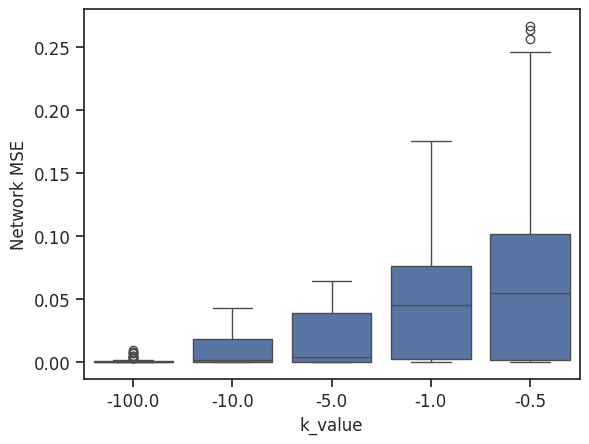

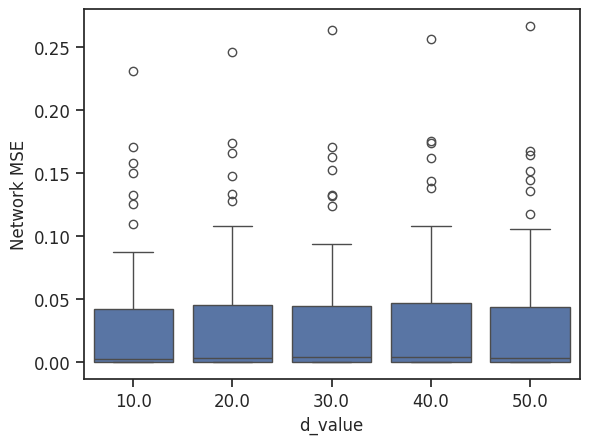

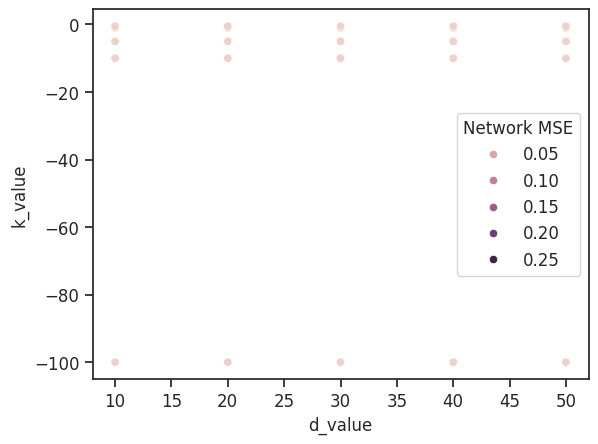

In [14]:
sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="k_value", y='Network MSE')
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_k.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", y='Network MSE')
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mMSE[plt_perturb_mMSE["model"]=="student_division_same_input"], x="d_value", hue='Network MSE', y="k_value")
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_k_d.pdf", bbox_inches="tight")
plt.show()

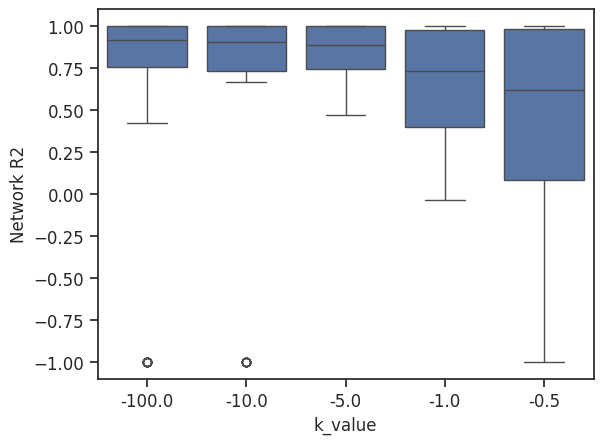

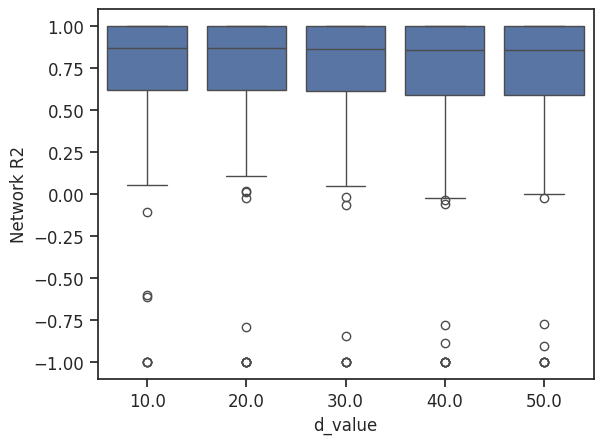

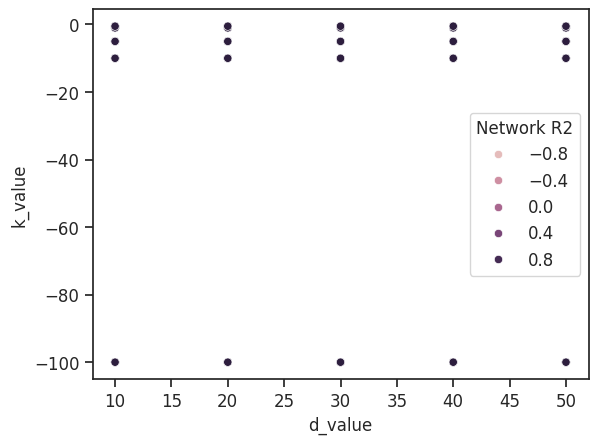

In [15]:
sns.boxplot(data=plt_perturb_mR2[plt_perturb_mR2["model"]=="student_division_same_input"], x="k_value", y='Network R2')
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_k.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=plt_perturb_mR2[plt_perturb_mR2["model"]=="student_division_same_input"], x="d_value", y='Network R2')
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_mMSE_d.pdf", bbox_inches="tight")
plt.show()

sns.scatterplot(data=plt_perturb_mR2[plt_perturb_mR2["model"]=="student_division_same_input"], x="d_value", hue='Network R2', y="k_value")
# plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_params_k_d.pdf", bbox_inches="tight")
plt.show()

In [16]:
# perturb_MSE = perturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
# unperturb_MSE = unperturb_data.groupby(["setting", "k_value", "d_value", "inhibited_node"]).apply(compute_MSE, true_model_name="teacher_no_pertrub_true").reset_index()

# perturb_R2 = perturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_5", axis=1)
# unperturb_R2 = unperturb_data.groupby(["setting", "repeat", "k_value", "d_value", "inhibited_node"]).apply(compute_R2, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_5", axis=1)


# avg_perturb_MSE = perturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
# avg_unperturb_MSE = unperturb_MSE.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
# avg_perturb_R2 = perturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()
# avg_unperturb_R2 = unperturb_R2.groupby(["setting", "k_value", "d_value", "inhibited_node", "model"]).mean().drop("repeat", axis=1).reset_index()

# plt_perturb_mMSE = avg_perturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network MSE", var_name="node")
# plt_unperturb_mMSE = avg_unperturb_MSE.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network MSE", var_name="node")
# plt_perturb_mR2 = avg_perturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network R2", var_name="node")
# plt_unperturb_mR2 = avg_unperturb_R2.melt(id_vars=["setting", "k_value", "d_value", "inhibited_node", "model"], value_name="Network R2", var_name="node")


# plt_perturb_mMSE = plt_perturb_mMSE.sample(n=len(plt_perturb_mMSE))
# plt_unperturb_mMSE = plt_unperturb_mMSE.sample(n=len(plt_unperturb_mMSE))
# plt_perturb_mR2 = plt_perturb_mR2.sample(n=len(plt_perturb_mR2))
# plt_unperturb_mR2 = plt_unperturb_mR2.sample(n=len(plt_unperturb_mR2))

In [17]:
d = 50
k = -5

sel_perturb_MSE = perturb_MSE[(perturb_MSE["d_value"]==d)&
                           (perturb_MSE["k_value"]==k)]
# sel_unperturb_MSE = unperturb_MSE[(unperturb_MSE["d_value"]==d)& 
#                                (unperturb_MSE["k_value"]==k)]

sel_perturb_R2 = perturb_R2[(perturb_R2["d_value"]==d)& 
                        (perturb_R2["k_value"]==k)]
# sel_unperturb_R2 = unperturb_R2[(unperturb_R2["d_value"]==d)& 
#                             (unperturb_R2["k_value"]==k)]


sel_perturb_MSE   = sel_perturb_MSE.drop(["k_value", "d_value"], axis=1)
# sel_unperturb_MSE = sel_unperturb_MSE.drop(["k_value", "d_value"], axis=1)
sel_perturb_R2    = sel_perturb_R2.drop(["k_value", "d_value"], axis=1)
# sel_unperturb_R2  = sel_unperturb_R2.drop(["k_value", "d_value"], axis=1)


In [18]:
# sel_perturb_MMD   = pd.read_csv(f"{folder}results_perturbed_MMD.csv", index_col=0)
# sel_unperturb_MMD = pd.read_csv(f"{folder}results_unperturbed_MMD.csv", index_col=0)
# sel_perturb_EMD   = pd.read_csv(f"{folder}results_perturbed_EMD.csv", index_col=0)
# sel_unperturb_EMD = pd.read_csv(f"{folder}results_unperturbed_EMD.csv", index_col=0)

# sel_perturb_MMD   = sel_perturb_MMD.drop(["k_value", "d_value"], axis=1)
# sel_unperturb_MMD = sel_unperturb_MMD.drop(["k_value", "d_value"], axis=1)
# sel_perturb_EMD   = sel_perturb_EMD.drop(["k_value", "d_value"], axis=1)
# sel_unperturb_EMD = sel_unperturb_EMD.drop(["k_value", "d_value"], axis=1)

In [19]:
sel_perturb_R2["model"].unique()

array(['student_division_random_input', 'student_division_same_input',
       'teacher_division_random_input', 'teacher_division_same_input',
       'teacher_k_inhibition_true', 'untrained_division_random_input',
       'untrained_division_same_input'], dtype=object)

In [20]:
sel_perturb_R2.loc[(sel_perturb_R2.loc[sel_perturb_R2["model"]=="student_division_same_input", output_markers] < -100).index, :]

,setting,repeat,inhibited_node,model,mek12,erk12,hsp27,mkk4,p38,jnk12,ikk,ikb,ras,pi3k,akt,map3k1,map3k7
11971,342.0,0.0,mek12,student_division_same_input,1.0,-0.144921,0.998573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11971,342.0,0.0,mek12,student_division_same_input,NaN,-0.144921,0.998573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11971,342.0,0.0,mek12,student_division_same_input,NaN,NaN,0.998573,0.999999,1.000000,0.999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11971,342.0,0.0,mek12,student_division_same_input,NaN,NaN,NaN,NaN,NaN,0.999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11971,342.0,0.0,mek12,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14799,422.0,4.0,hsp27,student_division_same_input,NaN,NaN,0.999993,0.999979,0.999992,0.999992,0.999999,1.0,NaN,0.999997,0.999998,0.99999,NaN
14799,422.0,4.0,hsp27,student_division_same_input,NaN,NaN,0.999993,0.999979,0.999992,0.999992,0.999999,1.0,NaN,NaN,NaN,0.99999,NaN
14799,422.0,4.0,hsp27,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,0.999999,1.0,NaN,NaN,0.999998,NaN,NaN
14799,422.0,4.0,hsp27,student_division_same_input,NaN,NaN,0.999993,NaN,0.999992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
sel_perturb_R2[sel_perturb_R2["model"]=="student_division_same_input"][((sel_perturb_R2.loc[sel_perturb_R2["model"]=="student_division_same_input", output_markers] < -1).sum(axis=1)>0)]

,setting,repeat,inhibited_node,model,mek12,erk12,hsp27,mkk4,p38,jnk12,ikk,ikb,ras,pi3k,akt,map3k1,map3k7
12671,362.0,0.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.028872,NaN,NaN,NaN,NaN,NaN
12678,362.0,1.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.102493,NaN,NaN,NaN,NaN,NaN
12685,362.0,2.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.401820,NaN,NaN,NaN,NaN,NaN
12671,362.0,0.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.028872,NaN,NaN,NaN,NaN,NaN
12678,362.0,1.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.102493,NaN,NaN,NaN,NaN,NaN
12685,362.0,2.0,ikk,student_division_same_input,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.401820,NaN,NaN,NaN,NaN,NaN
12671,362.0,0.0,ikk,student_division_same_input,0.999999,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,-1.028872,0.999997,0.999995,0.999997,1.000000,NaN
12678,362.0,1.0,ikk,student_division_same_input,1.000000,1.0,0.999998,1.000000,0.999999,1.000000,1.000000,-1.102493,1.000000,0.999984,0.999997,0.999999,NaN
12685,362.0,2.0,ikk,student_division_same_input,1.000000,1.0,0.999999,0.999999,0.999999,0.999999,1.000000,-1.401820,1.000000,0.999999,1.000000,0.999998,NaN
13546,387.0,0.0,pi3k,student_division_same_input,1.000000,1.0,0.898983,0.955005,0.924101,0.943676,0.907067,0.896562,1.000000,0.999999,-1.004884,0.949213,NaN


# R2 - matched inputs

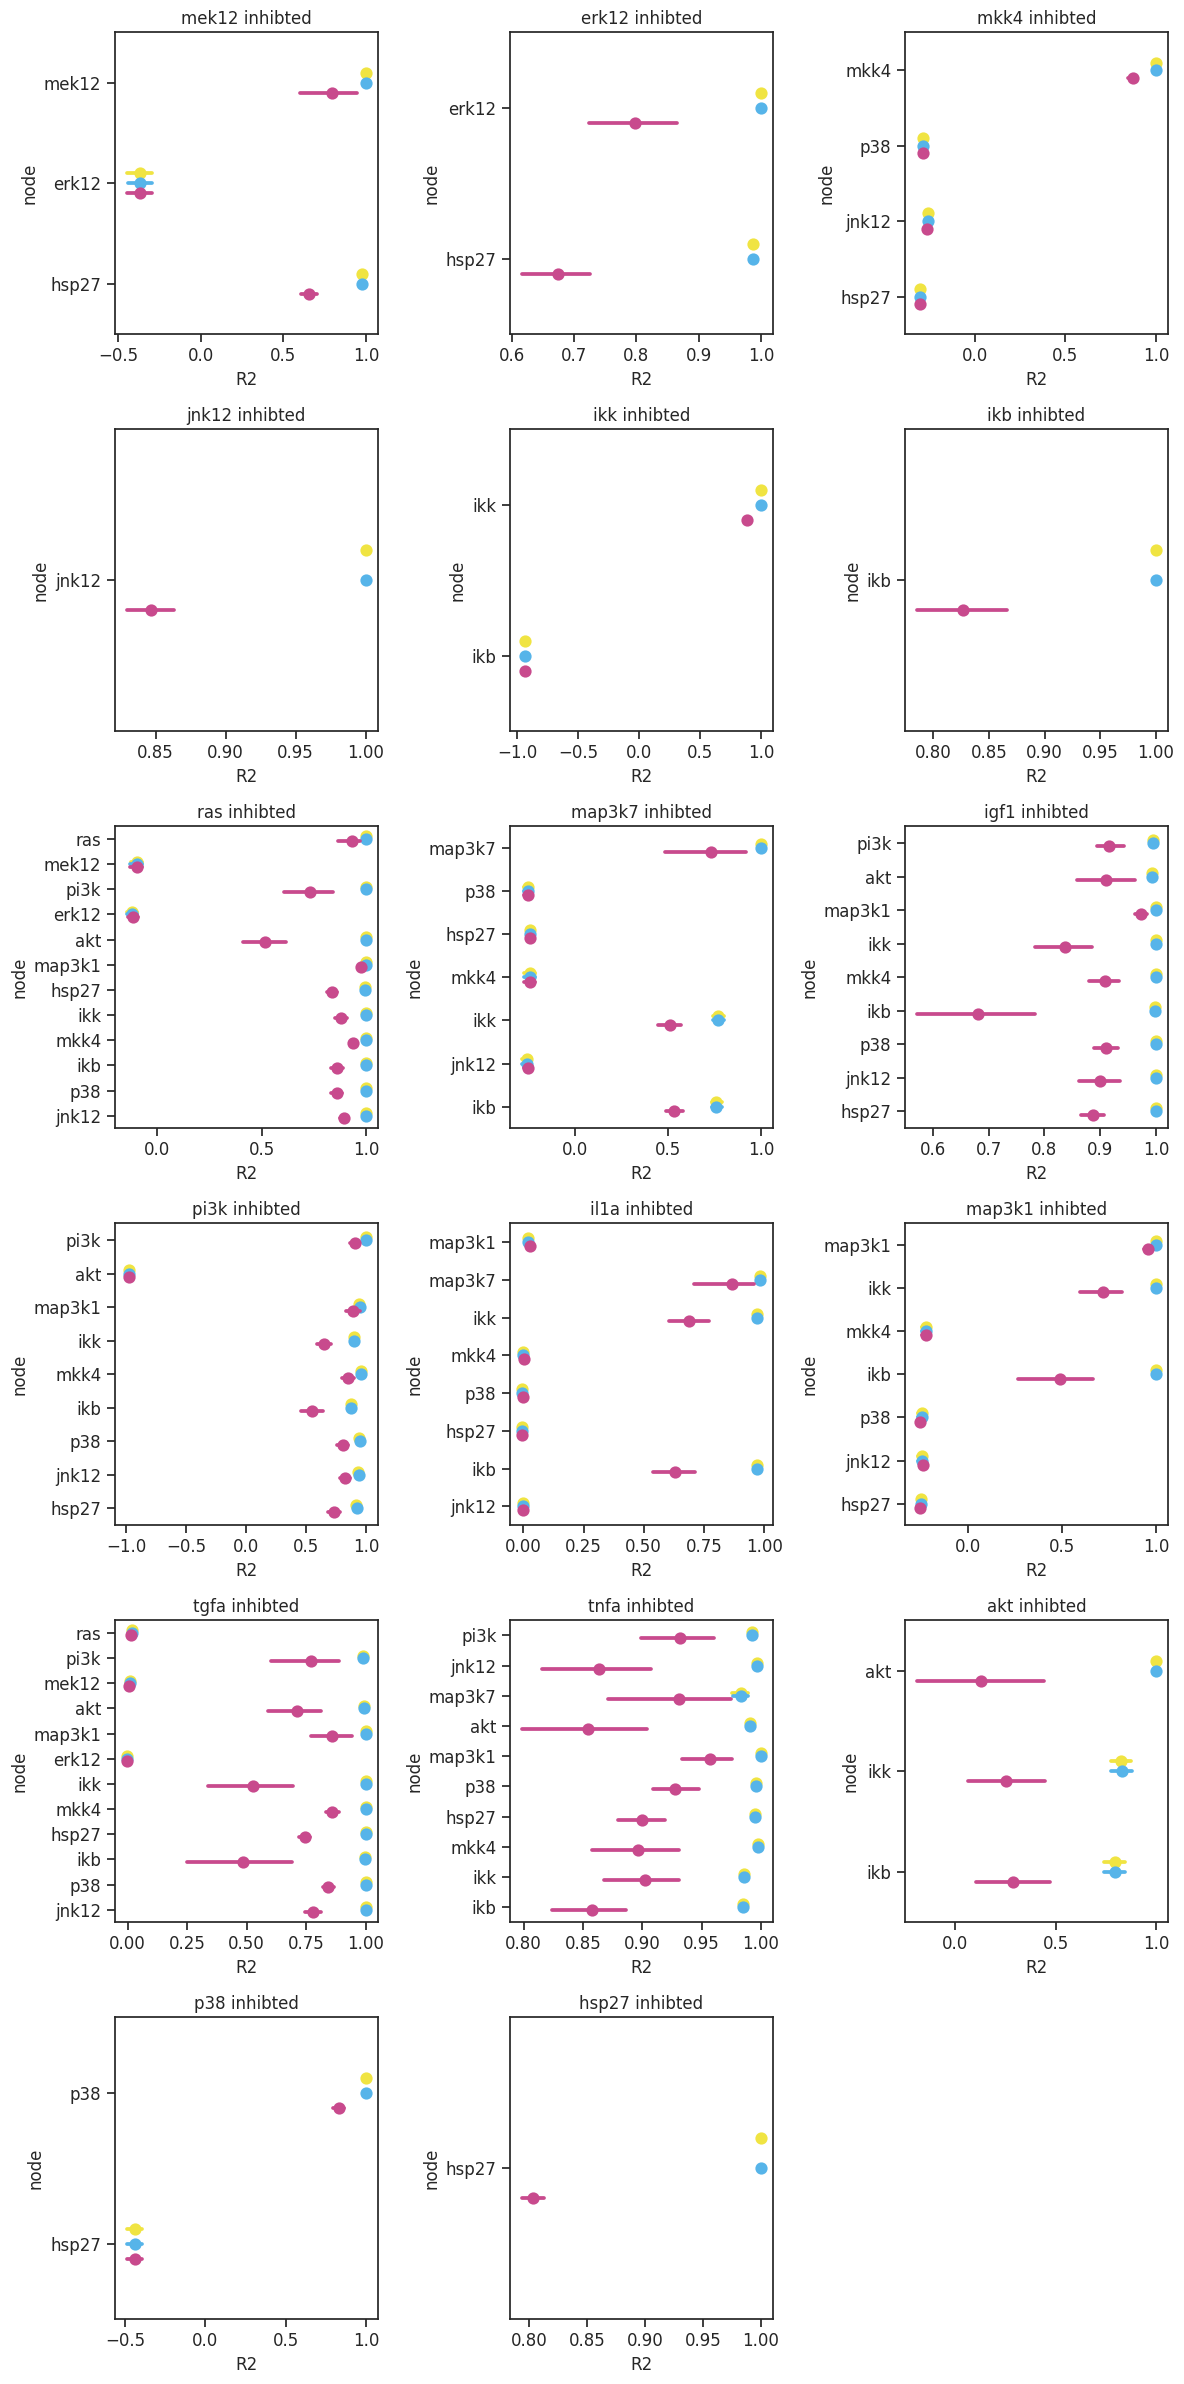

In [22]:
fig, axes = plt.subplots(nrows=6, ncols=3)
axes=axes.flatten() 
for i in range(len(axes)):
    ax = axes[i]
    if i > len(markers)-1:
        ax.remove()
    else:
        m=markers[i]
        temp = sel_perturb_R2[(sel_perturb_R2["model"].isin(["student_division_same_input", 
                                                            "untrained_division_same_input",
                                                           "teacher_division_same_input"])) &
        (sel_perturb_R2["inhibited_node"]==m)]
        temp = temp[["setting", "inhibited_node","model", "repeat"]+reachable_nodes[m]]
        temp = temp.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
        temp.loc[temp["R2"]<-1, "R2"] = -1
        sns.pointplot(data=temp, y="node", x="R2", linestyles="none", hue="model", dodge=0.2, palette=perturbation_models_dict,
                     legend=False, ax=ax)
        ax.title.set_text(f"{m} inhibted")

fig.set_size_inches(12,24)
fig.tight_layout()
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_downstream_only_panels.pdf", bbox_inches="tight")
plt.show()

In [23]:
avg_r2_over_5_folds_per_node = []
for m in markers:
    temp = sel_perturb_R2[(sel_perturb_R2["model"].isin(["student_division_same_input", 
                                                            "untrained_division_same_input",
                                                           "teacher_division_same_input"])) &
        (sel_perturb_R2["inhibited_node"]==m)]
    temp = temp[["setting", "inhibited_node","model", "repeat"]+reachable_nodes[m]]
    temp = temp.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
    temp.loc[temp["R2"]<-1, "R2"] = -1
    temp = temp.groupby(["inhibited_node", "model", "node"]).mean('numeric_only')
    avg_r2_over_5_folds_per_node.append(temp)



In [24]:
r2 = pd.concat(avg_r2_over_5_folds_per_node).reset_index()
r2

,inhibited_node,model,node,setting,repeat,R2
0,mek12,student_division_same_input,erk12,342.0,2.0,-0.370881
1,mek12,student_division_same_input,hsp27,342.0,2.0,0.978723
2,mek12,student_division_same_input,mek12,342.0,2.0,1.000000
3,mek12,teacher_division_same_input,erk12,342.0,2.0,-0.370881
4,mek12,teacher_division_same_input,hsp27,342.0,2.0,0.978807
...,...,...,...,...,...,...
274,p38,untrained_division_same_input,hsp27,417.0,2.0,-0.441620
275,p38,untrained_division_same_input,p38,417.0,2.0,0.833116
276,hsp27,student_division_same_input,hsp27,422.0,2.0,0.999997
277,hsp27,teacher_division_same_input,hsp27,422.0,2.0,1.000000


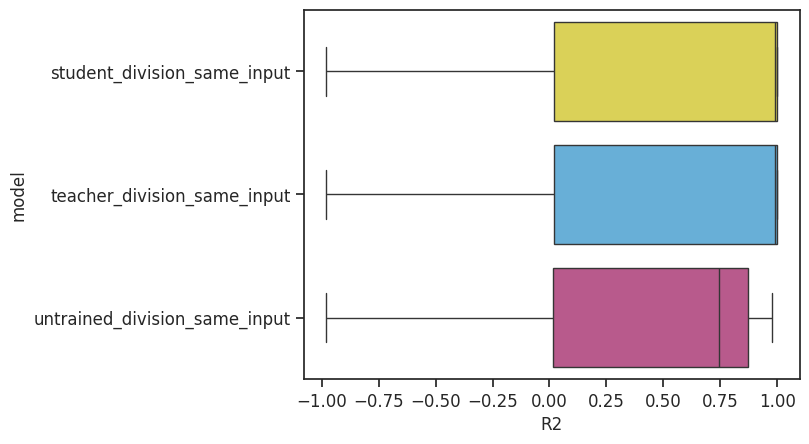

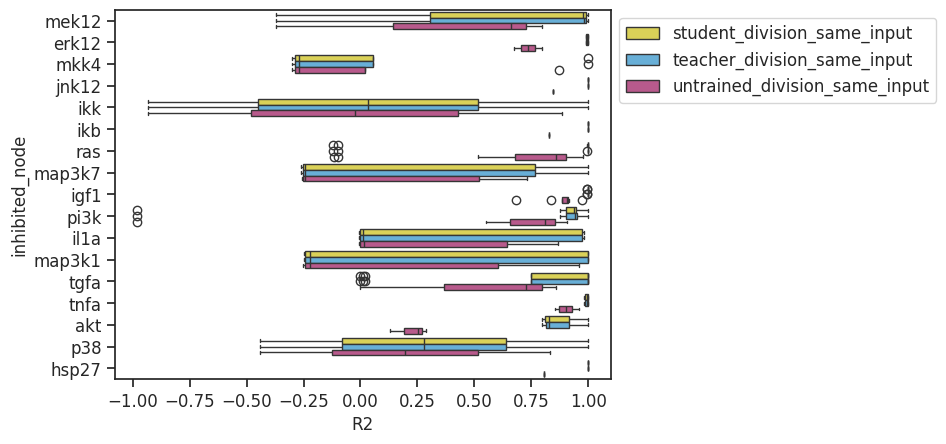

In [25]:
sns.boxplot(data=r2, x="R2", y="model", hue="model", palette=perturbation_models_dict)
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_R2_same_inputs_downstream_only.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=r2, x="R2", y="inhibited_node", hue="model", palette=perturbation_models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [26]:
avg_r2 = r2.groupby(["model", "inhibited_node"]).mean(numeric_only=True).reset_index().sort_values(["model", "inhibited_node"])
student_r2 = avg_r2[avg_r2["model"]=="student_division_same_input"].reset_index(drop=True)
untrained_r2 = avg_r2[avg_r2["model"]=="untrained_division_same_input"].reset_index(drop=True)

student_r2["delta_R2"] = student_r2["R2"] - untrained_r2["R2"]
student_r2.sort_values("delta_R2")

,model,inhibited_node,setting,repeat,R2,delta_R2
11,student_division_same_input,mkk4,352.0,2.0,0.039442,0.032317
5,student_division_same_input,ikk,362.0,2.0,0.032689,0.058272
12,student_division_same_input,p38,417.0,2.0,0.280214,0.084465
16,student_division_same_input,tnfa,407.0,2.0,0.992288,0.090271
6,student_division_same_input,il1a,392.0,2.0,0.366135,0.090406
9,student_division_same_input,map3k7,377.0,2.0,0.217738,0.107174
3,student_division_same_input,igf1,382.0,2.0,0.998388,0.118472
8,student_division_same_input,map3k1,397.0,2.0,0.291435,0.119106
14,student_division_same_input,ras,372.0,2.0,0.814717,0.130186
13,student_division_same_input,pi3k,387.0,2.0,0.722624,0.139484


In [27]:
student_r2.sort_values("R2")

,model,inhibited_node,setting,repeat,R2,delta_R2
5,student_division_same_input,ikk,362.0,2.0,0.032689,0.058272
11,student_division_same_input,mkk4,352.0,2.0,0.039442,0.032317
9,student_division_same_input,map3k7,377.0,2.0,0.217738,0.107174
12,student_division_same_input,p38,417.0,2.0,0.280214,0.084465
8,student_division_same_input,map3k1,397.0,2.0,0.291435,0.119106
6,student_division_same_input,il1a,392.0,2.0,0.366135,0.090406
10,student_division_same_input,mek12,342.0,2.0,0.535947,0.174279
13,student_division_same_input,pi3k,387.0,2.0,0.722624,0.139484
15,student_division_same_input,tgfa,402.0,2.0,0.750076,0.200995
14,student_division_same_input,ras,372.0,2.0,0.814717,0.130186


# MSE matched inputs

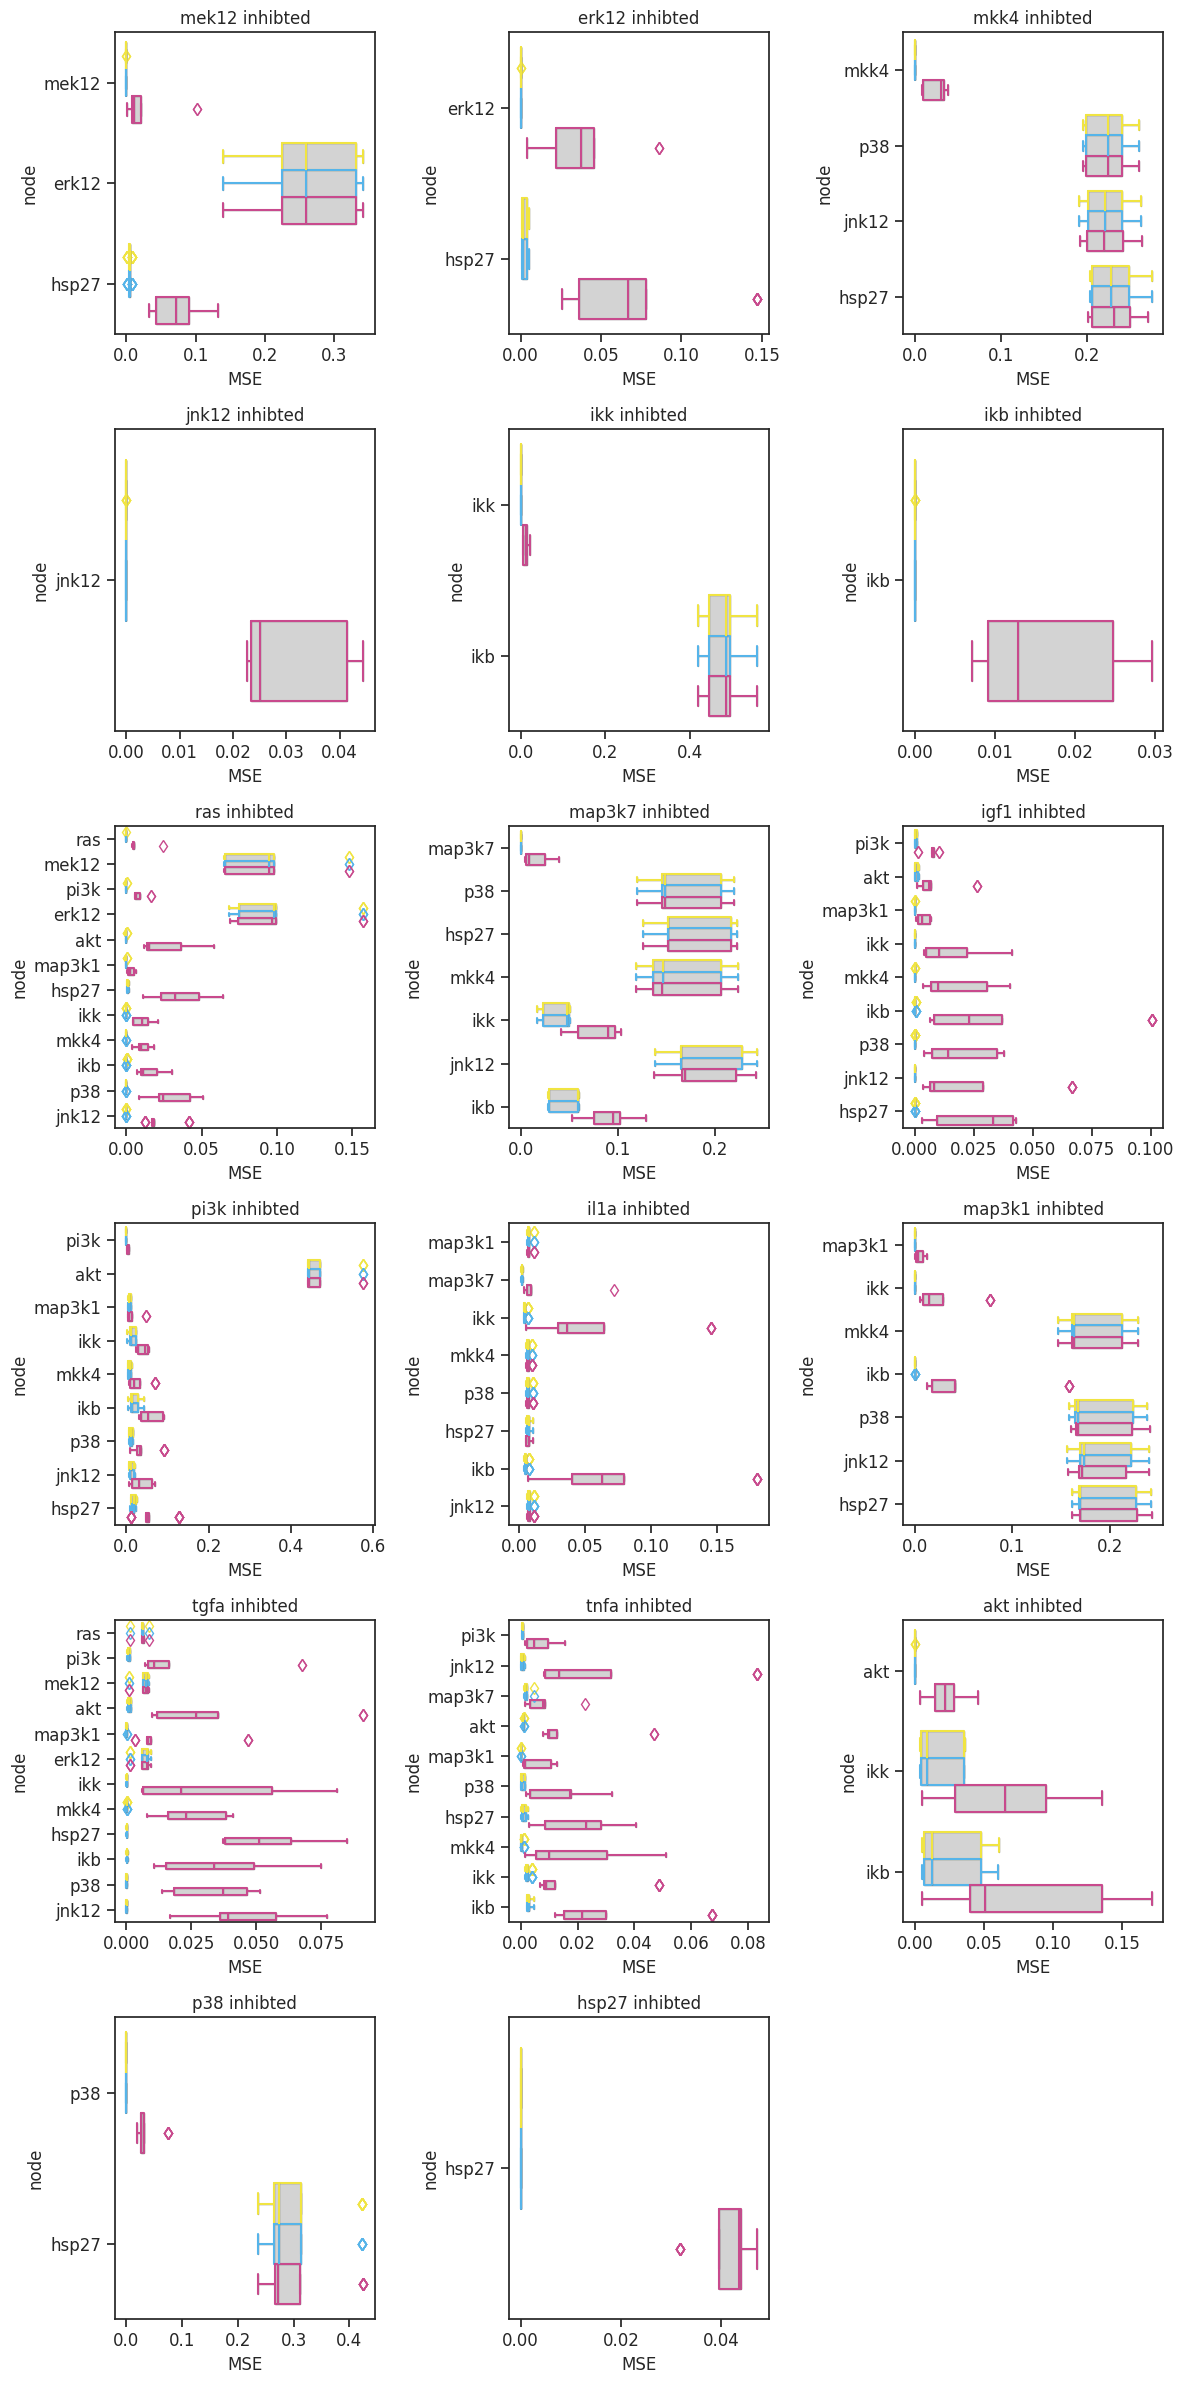

In [36]:
fig, axes = plt.subplots(nrows=6, ncols=3)
axes=axes.flatten() 
for i in range(len(axes)):
    ax = axes[i]
    if i > len(markers)-1:
        ax.remove()
    else:
        m=markers[i]
        temp = sel_perturb_MSE[(sel_perturb_MSE["model"].isin(["student_division_same_input", 
                                                              "untrained_division_same_input",
                                                              "teacher_division_same_input"]))&
        (sel_perturb_MSE["inhibited_node"]==m)]
        temp = temp[["setting", "inhibited_node","model", "repeat"]+reachable_nodes[m]]
        temp = temp.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
        # temp.loc[temp["R2"]<-1, "R2"] = -1
        sns.boxplot(data=temp, y="node", x="MSE", hue="model", palette={"student_division_same_input": "lightgrey", 
                                                                       "untrained_division_same_input": "lightgrey",
                                                                       "teacher_division_same_input": "lightgrey"},
                   legend=False, showfliers=False, ax=ax)
        sns.boxplot(data=temp, y="node", x="MSE", hue="model", fill=False, flierprops={"marker": "d"}, 
                    palette=perturbation_models_dict, ax=ax, legend=False)
        ax.title.set_text(f"{m} inhibted")

fig.set_size_inches(12,24)
fig.tight_layout()
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs_downstream_only_panels.pdf", bbox_inches="tight")
plt.show()

In [37]:
avg_mse_over_5_folds_per_node = []
for m in markers:
    temp = sel_perturb_MSE[(sel_perturb_MSE["model"].isin(["student_division_same_input", 
                                                            "untrained_division_same_input",
                                                           "teacher_division_same_input"])) &
        (sel_perturb_MSE["inhibited_node"]==m)]
    temp = temp[["setting", "inhibited_node","model", "repeat"]+reachable_nodes[m]]
    temp = temp.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
    temp = temp.groupby(["inhibited_node", "model", "node"]).mean('numeric_only')
    avg_mse_over_5_folds_per_node.append(temp)



In [38]:
mse = pd.concat(avg_mse_over_5_folds_per_node).reset_index()
mse

,inhibited_node,model,node,setting,repeat,MSE
0,mek12,student_division_same_input,erk12,342.0,6.0,2.591424e-01
1,mek12,student_division_same_input,hsp27,342.0,6.0,4.503467e-03
2,mek12,student_division_same_input,mek12,342.0,6.0,1.471239e-09
3,mek12,teacher_division_same_input,erk12,342.0,6.0,2.591424e-01
4,mek12,teacher_division_same_input,hsp27,342.0,6.0,4.486436e-03
...,...,...,...,...,...,...
274,p38,untrained_division_same_input,hsp27,417.0,6.0,3.026735e-01
275,p38,untrained_division_same_input,p38,417.0,6.0,3.493745e-02
276,hsp27,student_division_same_input,hsp27,422.0,6.0,7.040700e-07
277,hsp27,teacher_division_same_input,hsp27,422.0,6.0,0.000000e+00


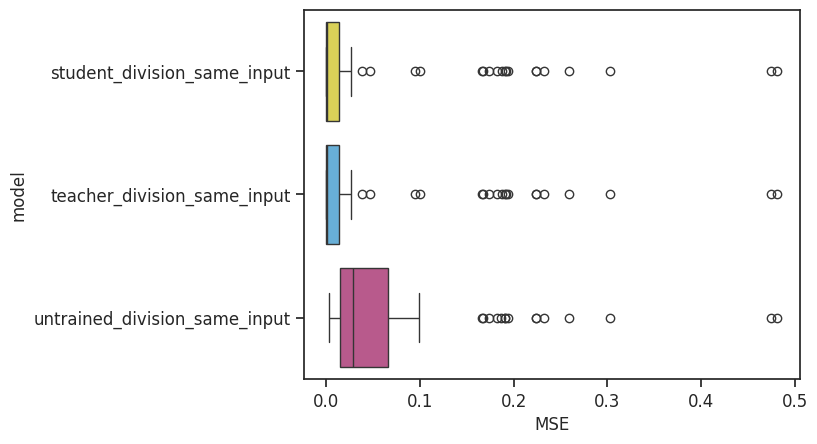

In [39]:
sns.boxplot(data=mse, x="MSE", y="model", hue="model", palette=perturbation_models_dict)
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Syntehtic_perturb_MSE_same_inputs_downstream_nodes_only.pdf", bbox_inches="tight")


In [40]:
avg_mse = mse.groupby(["model", "inhibited_node"]).mean(numeric_only=True).reset_index().sort_values(["model", "inhibited_node"])
student_mse = avg_mse[avg_mse["model"]=="student_division_same_input"].reset_index(drop=True)
untrained_mse = avg_mse[avg_mse["model"]=="untrained_division_same_input"].reset_index(drop=True)

student_mse["delta_MSE"] = student_mse["MSE"] - untrained_mse["MSE"]
student_mse.sort_values("delta_MSE")

,model,inhibited_node,setting,repeat,MSE,delta_MSE
1,student_division_same_input,erk12,347.0,6.0,1.283864e-03,-0.053594
0,student_division_same_input,akt,412.0,6.0,1.474377e-02,-0.041735
2,student_division_same_input,hsp27,422.0,6.0,7.040700e-07,-0.041177
10,student_division_same_input,mek12,342.0,6.0,8.788197e-02,-0.032689
7,student_division_same_input,jnk12,357.0,6.0,6.516733e-07,-0.031359
15,student_division_same_input,tgfa,402.0,6.0,1.781909e-03,-0.024915
13,student_division_same_input,pi3k,387.0,6.0,6.273811e-02,-0.021150
12,student_division_same_input,p38,417.0,6.0,1.511118e-01,-0.017694
3,student_division_same_input,igf1,382.0,6.0,1.629073e-04,-0.017293
6,student_division_same_input,il1a,392.0,6.0,6.356244e-03,-0.017186


In [41]:
student_mse.sort_values("MSE")

,model,inhibited_node,setting,repeat,MSE,delta_MSE
4,student_division_same_input,ikb,367.0,6.0,6.460214e-07,-0.016690
7,student_division_same_input,jnk12,357.0,6.0,6.516733e-07,-0.031359
2,student_division_same_input,hsp27,422.0,6.0,7.040700e-07,-0.041177
3,student_division_same_input,igf1,382.0,6.0,1.629073e-04,-0.017293
16,student_division_same_input,tnfa,407.0,6.0,1.236792e-03,-0.015581
1,student_division_same_input,erk12,347.0,6.0,1.283864e-03,-0.053594
15,student_division_same_input,tgfa,402.0,6.0,1.781909e-03,-0.024915
6,student_division_same_input,il1a,392.0,6.0,6.356244e-03,-0.017186
0,student_division_same_input,akt,412.0,6.0,1.474377e-02,-0.041735
14,student_division_same_input,ras,372.0,6.0,1.622599e-02,-0.014176


# MMD - all inputs

MMD and Wasserstein are currently calculated over the high-dimension distribution using all markers. I am not sure if we can plot in one figure a boxplot oid with the MMD/WD based only on the reachable nodes, because that would mean that the MMD/WD is calculated on a different number of markers each time. This might not be comparable or can't be taken into the same reference. 

# Predictions of poorly predicted settings

In [42]:
pred = perturb_data[(perturb_data["model"]=="student_division_same_input") & 
            (perturb_data["k_value"]==k) & (perturb_data["d_value"]==d) &
            (perturb_data["setting"]==362)]

true = perturb_data[(perturb_data["model"] == "teacher_k_inhibition_true") & 
            (perturb_data["k_value"]==k) & (perturb_data["d_value"]==d) & 
            (perturb_data["setting"]==362)]

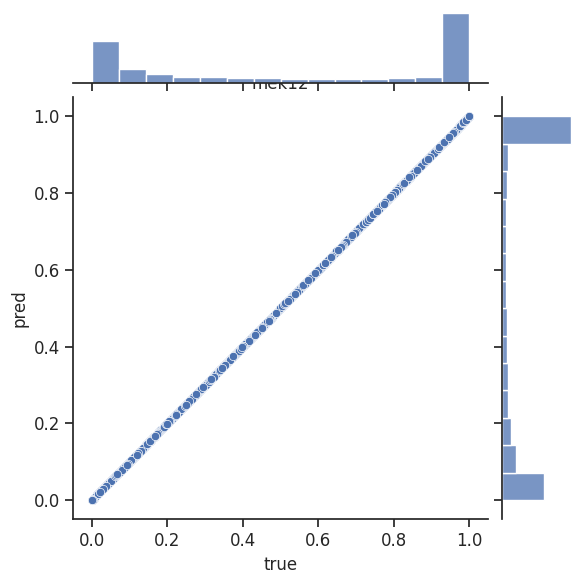

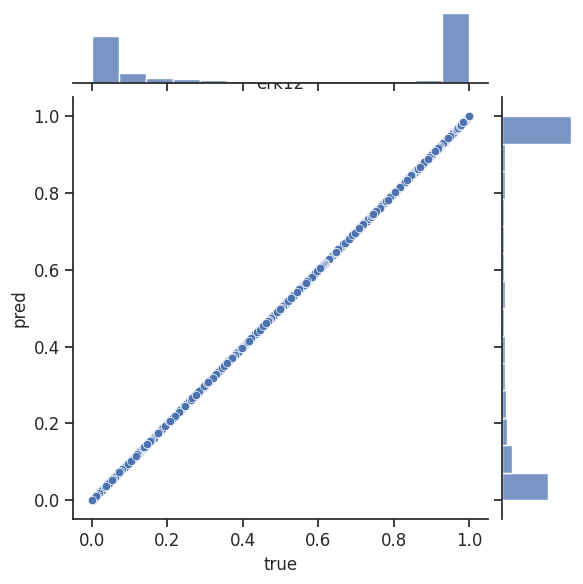

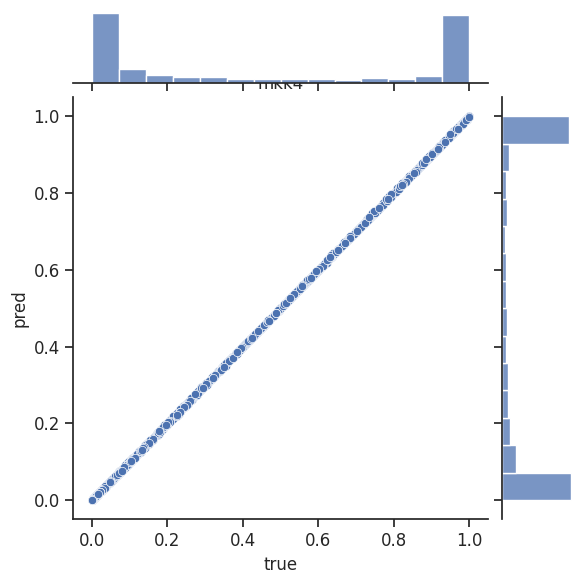

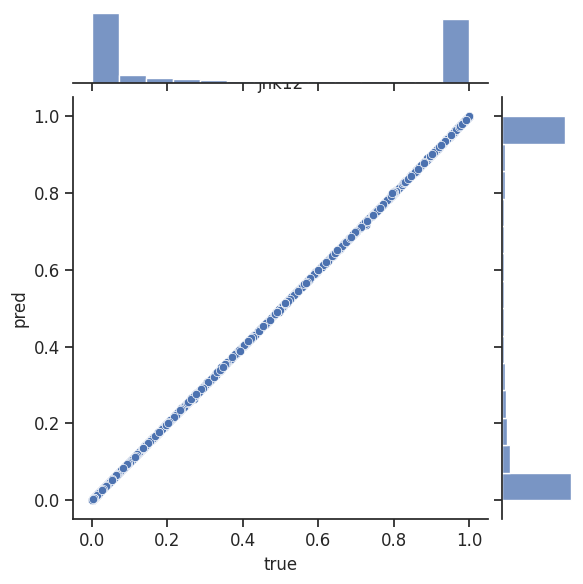

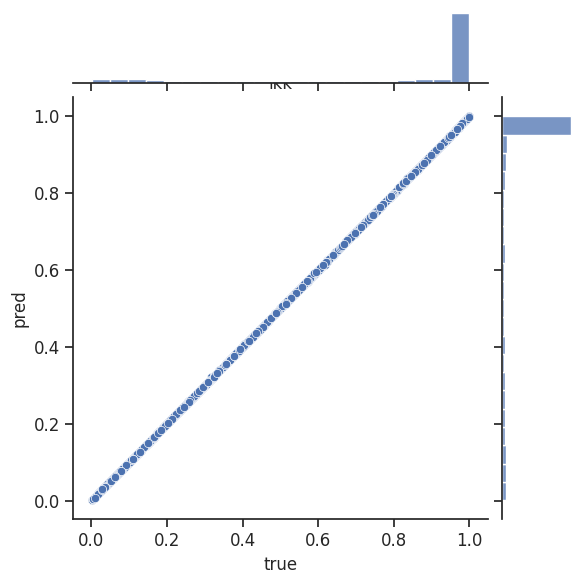

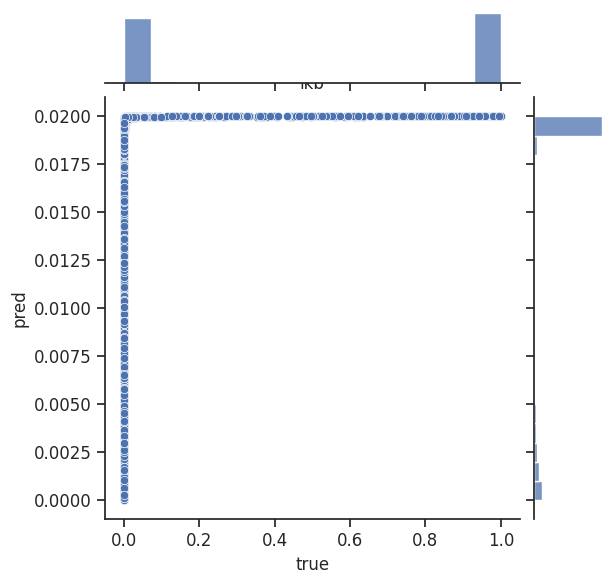

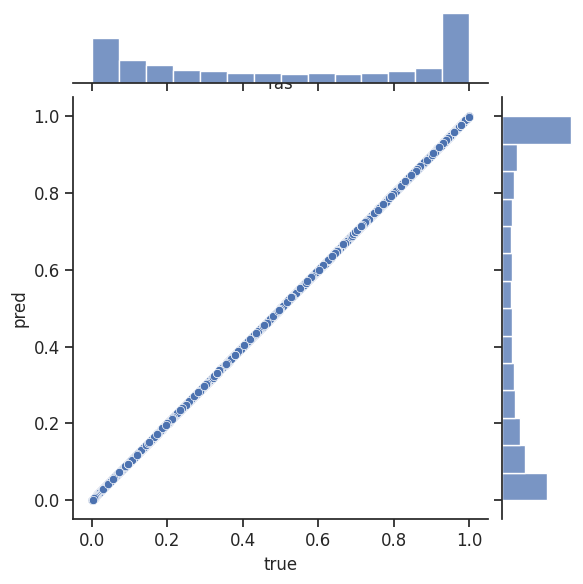

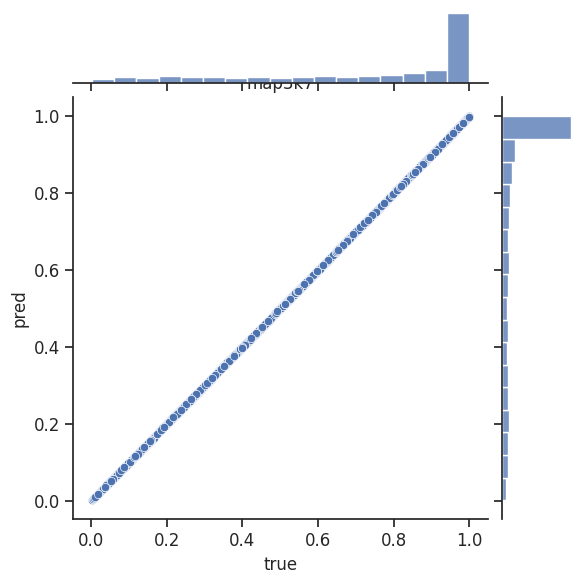

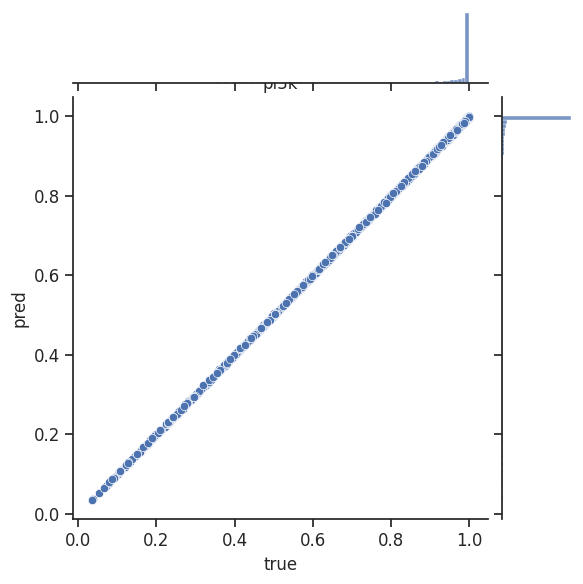

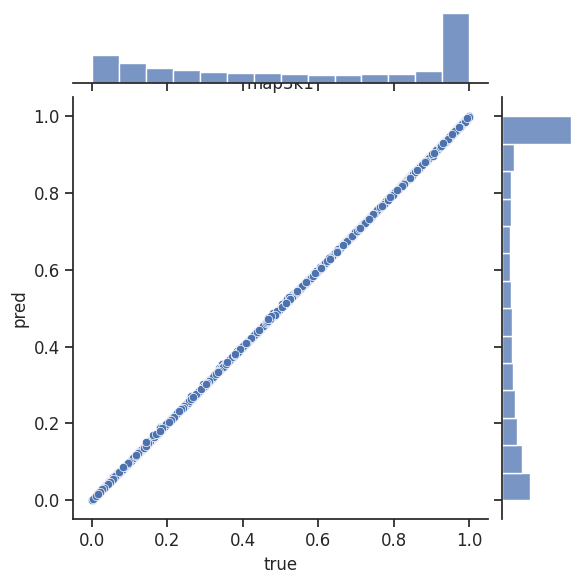

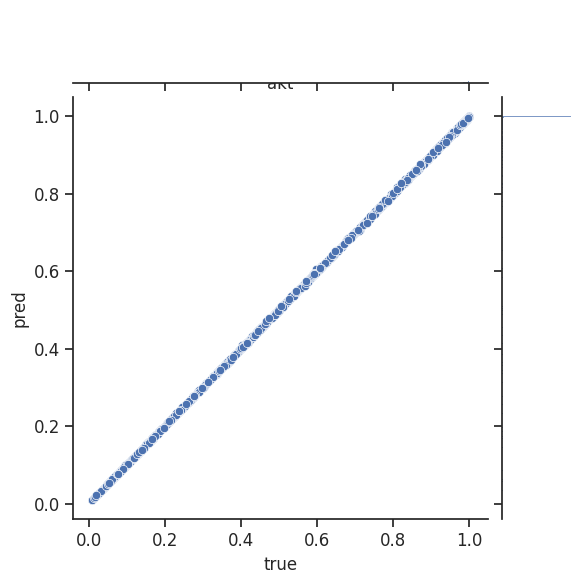

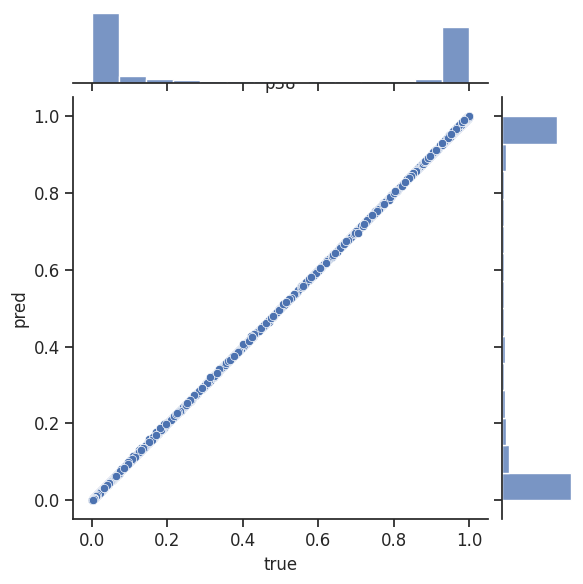

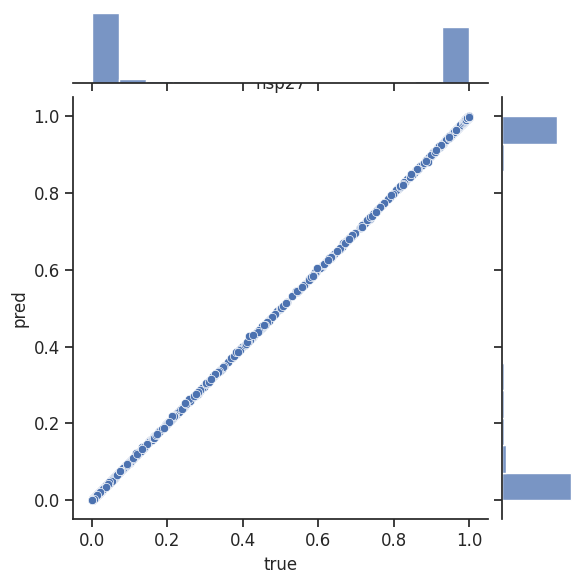

In [43]:
for m in output_markers:
    sns.jointplot(y=pred[m], x=true[m])
    plt.ylabel("pred")
    plt.xlabel("true")
    plt.title(m)
    plt.show()